# Dog vision classifier

The goal of this project is to create a model that identify different dog breeds. Model training data comes from a [kaggle competition](https://www.kaggle.com/c/dog-breed-identification/data). This notebook will keep the discussion to a minimum, as the project is discussed in detail in an accompanying [report](https://www.overleaf.com/project/605cfede89f087027f10e6a1). All relevant files used for this project can be viewed [here](https://www.dropbox.com/home/%5BOrganisering%5D/09.%20Skole/DAT550%20-%20Data%20Mining%20and%20Deep%20Learning/Dog%20Vision%20Project)

The outline of this notebook is as follows:

1. Import and verify data and gpu
2. Wrangle data to fit the model
3. Exploratory Data Analysis
4. Preparing data for model
5. Create model
6. Run model
7. Model selection

# 1. Import and verify data

In [1]:
from numpy.random import seed
seed(5)

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import os, os.path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import datetime

#import os

# NB! If this prints 0 GPUs, training will be done using the CPU, which
# will take a very long time
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
labels = pd.read_csv('./data/labels.csv')
print('Number of labels: ', len(labels))
labels.head()

Number of labels:  10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


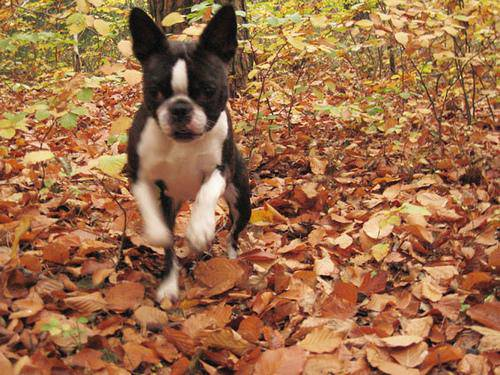

In [4]:
#sample random image
Image(filename='./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

In [5]:
print('training images: ', len([image for image in os.listdir('./data/train/')]))
print('test images: ', len([image for image in os.listdir('./data/test/')]))

training images:  10222
test images:  10357


There are 10222 labels with 10222 corresponding training images, while there are 10357 test images without labels. 

# 2. Wrangle data to fit the model

In order to use the data in a tensorflow neural network model, it needs to be reshaped into a tensor. But first, we will need to split the training images into a train and test set. Each datapoint will consist of a single feature, the filepath of the image, and its corresponding label, a bool array of all dog breeds where index of correct dog breed has value True, all others false.

feature = filepath/of/image0, filepath/of/image1....

label = False, True, False, False..... (120 values, one for each breed. Only correct breed has value True)


10222
./data/train/572380f98621937eff104196578dc6c0.jpg


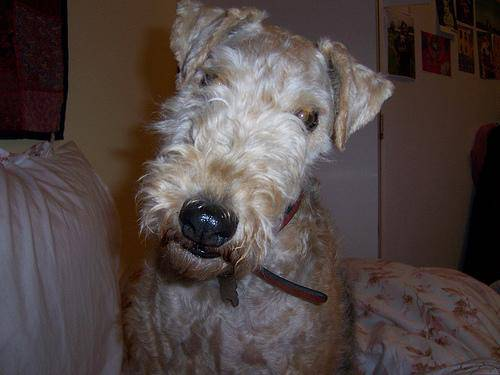

In [6]:
# build a feature list of filepaths for all training images

X = []
test_images = []

[X.append('./data/train/' + filename) for filename in os.listdir('./data/train/')];
[test_images.append('./data/test/' + filename) for filename in os.listdir('./data/test/')];

# only use a small set of test images
test_images = test_images[:10]

print(len(X))
print(X[3498])

# test random image
Image(filename=X[5484])

In [7]:
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [8]:
X[0]

'./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [9]:
unique_breeds = labels['breed'].unique()
len(unique_breeds)

120

In [10]:
y = [breed == unique_breeds for breed in labels['breed'].values]

print('length of y: ', len(y))
print('bool values in each breed: ', len(y[0]))

# Let's test a random sample
sample_nr = 3518
print('true value index: ', np.where(y[sample_nr])[0][0])
print('breed should be: ', unique_breeds[np.where(y[sample_nr])][0])

print('true breed is: ', labels.iloc[sample_nr]['breed'])

length of y:  10222
bool values in each breed:  120
true value index:  79
breed should be:  irish_wolfhound
true breed is:  irish_wolfhound


In [11]:
print(len(X))
print(len(y))
print(X[0])
print(y[0])

10222
10222
./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


The data is now shaped into the desired form.

# 3. Exploratory Data Analysis

Let's do a quick exploration of the data

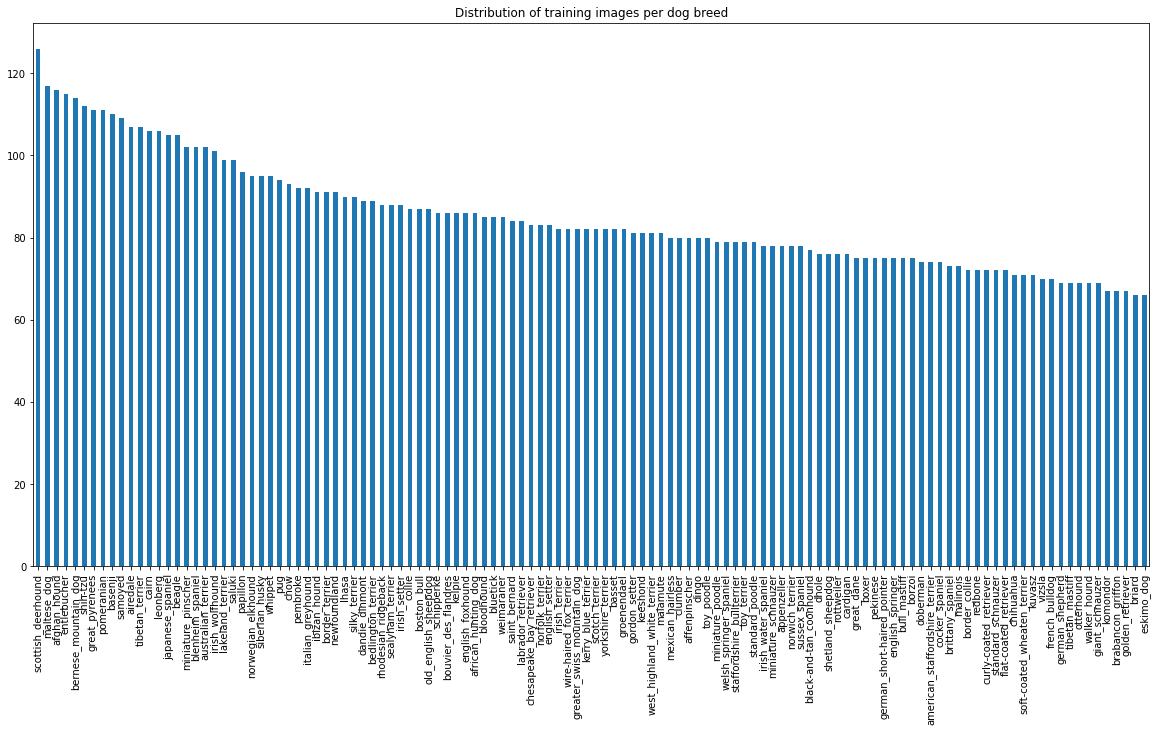

In [12]:
labels['breed'].value_counts().plot.bar(figsize=(20,10), title='Distribution of training images per dog breed');

In [13]:
print('number of dog breeds: ', len(labels['breed'].unique()))
print('median of samples: ', labels['breed'].value_counts().median())
print('mean of samples: ', labels['breed'].value_counts().mean())
print(labels['breed'].value_counts())

number of dog breeds:  120
median of samples:  82.0
mean of samples:  85.18333333333334
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64


We observe that all dog breeds should have a sufficient number of training images for training the model. Each dog breed have 66-126 training images, with a mean and median of 85 and 82 samples.

# 4. Preparing data for model

In order to use the dataset made in the previous section, two more things needs to be done:
1. Preprocess images and turn it into tensors

All data used in tensorflow must come in the form of a tensor. A tensor can be thought of as a container which can house data in N-dimensions. For instance, a scalar is a 1-d tensor, matrix 2-d tensor and so on. Also, in order to leverage the GPU, the tensorified data is needed.

2. Shape tensor data

Running the model with the entire dataset takes a long time. For each epoch, we therefore only run randomized batches of all the available data. Tensor data will be shaped into a tensor tuple, of form `(image, label)`

In [14]:
# define parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [15]:
# create train/test dataset
np.random.seed(5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
def preprocess_image(image_path, height = IMG_HEIGHT, width = IMG_WIDTH):
    """
    Loads an image from filepath, resizes image, and converts it to a tensor 
    """
    # read image
    image = tf.io.read_file(image_path)
    # convert it to tensor with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    # normalize the color values (convert 0-255 value range to 0-1 range in order to speed up gpu processing)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # resize the image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    return image

The function above load and processes an image to a 224x224x3 image. What this means is that each picture is now composed of 50176 pixels (224\*224), with combinations of 3 colors; red, green and blue (RGB). This yields a total of 9 different color combinations, with values normalized between 0-1.

In [17]:
def create_training_data_batches(X, y):
    """
    Builds data batches for training datasets
    """

    # wrap image and label into a tensor object
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    
    # shuffle dataset
    dataset = dataset.shuffle(buffer_size=len(X))

    # get and preprocess image from image path
    dataset = dataset.map(lambda image_path, label: (preprocess_image(image_path), label))

    # batchify dataset
    dataset = dataset.batch(BATCH_SIZE)
  
    return dataset

In [18]:
def create_test_data_batches(test_data):
    """
    Builds test batches for test datasets
    """
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(test_data)))
    dataset = dataset.map(preprocess_image).batch(BATCH_SIZE)

    return dataset

In [19]:
training_set = create_training_data_batches(X_train, y_train)
validation_set = create_training_data_batches(X_test, y_test)
test_set = create_test_data_batches(test_images)

Let's visualize the data, here are the first 9 images from the training dataset

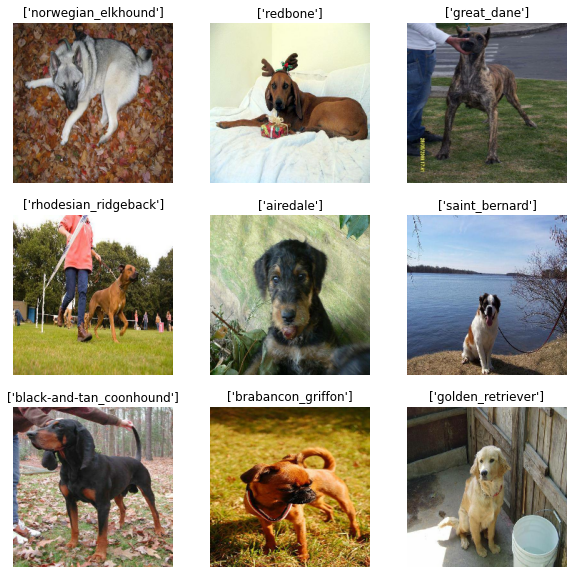

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i]])
        plt.axis("off")

# 5. Create model

Data has been prepared, and we are ready to build the model. In order to pick the best model, we will test different prebuilt models from [Tensorflow Hub](https://tfhub.dev/s?module-type=image-classification&tf-version=tf2). Selection below are based on the top 4 most downloaded models for Tensorflow 2:

| Model no | Name |  Batch input shape | Downloads (10.4.2021) |
| --- | --- | --- | -- |
| 1 | imagenet/mobilenet_v1_100_224/classification  | [None, 224, 224, 3] | 336.7k |
| 2 | imagenet/mobilenet_v2_100_224/classification  | [None, 224, 224, 3] | 214.3k |
| 3 | tf2-preview/mobilenet_v2/classification | [None, 224, 224, 3] | 111.7k |
| 4 | imagenet/mobilenet_v2_140_224/classification  | [None, 224, 224, 3] | 73.1k |

Success metrics used to evaluate the models will be net accuracy and loss (categorical cross entropy) after being trained and tested on the entire dataset. As it is hard to predicatable results (cuda GPU used introduces its own source of randomness), each model will be run 3 times, and average values will be used. 

The entire neural network will only consist of this model, and a fully connected output (dense) layer, mapping the results as probability in a 120-dimensional vector, where each vector rank value corresponds to predict rate of respective dog breed.

An early stopping callback will be used, terminating the training if 3 successive epochs does not improve the value accuracy.

In [88]:
NUMBER_OF_EPOCHS = 50
INPUT_SHAPE = [None, IMG_HEIGHT, IMG_WIDTH, 3] # batch, height, width, color channels
OUTPUT_SHAPE = len(unique_breeds)

# Model no 1
#MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4"

# Model no 2
#MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4"

# Model no 3
#MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

# Model no 4
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4"

In [89]:
def build_model(MODEL_URL):
    
    # Build model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),   # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 2 (output layer)
    ])

    # Compile model    
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])

    model.build(INPUT_SHAPE)
        
    return model

In [90]:
# early stopping stops the training if 3 epochs in a row does not produce a better value accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=3, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

In [91]:
model = build_model(MODEL_URL)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1001)              6158505   
_________________________________________________________________
dense_5 (Dense)              (None, 120)               120240    
Total params: 6,278,745
Trainable params: 120,240
Non-trainable params: 6,158,505
_________________________________________________________________


# 6. Run model

Each model defined in the last section is run, results are recorded in table in next section

In [25]:
model = build_model(MODEL_URL)

print("Running model: {}".format(MODEL_URL))

model.fit(
      x=training_set, 
      epochs=NUMBER_OF_EPOCHS,
      validation_data=validation_set,
      validation_freq=1,
      callbacks=[early_stopping]
      );

Running model: https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4
Epoch 1/50
224/224 [==============================] - 33s 121ms/step - loss: 2.6706 - accuracy: 0.4299 - val_loss: 0.7412 - val_accuracy: 0.7884
Epoch 2/50
224/224 [==============================] - 26s 115ms/step - loss: 0.3754 - accuracy: 0.8967 - val_loss: 0.6798 - val_accuracy: 0.7972
Epoch 3/50
224/224 [==============================] - 26s 115ms/step - loss: 0.2003 - accuracy: 0.9595 - val_loss: 0.6750 - val_accuracy: 0.8037
Epoch 4/50
224/224 [==============================] - 26s 114ms/step - loss: 0.1201 - accuracy: 0.9781 - val_loss: 0.6884 - val_accuracy: 0.8001
Epoch 5/50
224/224 [==============================] - 25s 111ms/step - loss: 0.0819 - accuracy: 0.9909 - val_loss: 0.6889 - val_accuracy: 0.8014
Epoch 6/50
224/224 [==============================] - 25s 112ms/step - loss: 0.0582 - accuracy: 0.9941 - val_loss: 0.7055 - val_accuracy: 0.7992


[0.664963   0.21421598 0.09713238 0.01426103 0.00370212]


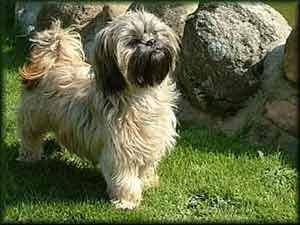

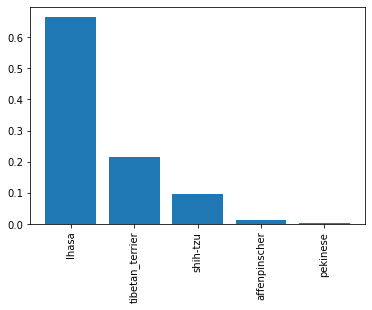

In [75]:
# Do a prediction on the test dataset (not used to train on)
def visualize_prediction(prediction):
    
    # sort the five highest predictions and return index
    top_five_prediction_indexes = prediction.argsort()[-5:][::-1]
    # find values of the index
    top_five_prediction_values = prediction[top_five_prediction_indexes]
    # get the breed names
    top_five_breed_labels = unique_breeds[top_five_prediction_indexes]
    
    plot_values = plt.bar(
        np.arange(len(top_five_breed_labels)), 
        top_five_prediction_values
    )
    
    # add breed name to bars
    plt.xticks(
        np.arange(len(top_five_breed_labels)),
        top_five_breed_labels,
        rotation="vertical"
    )

    print(top_five_prediction_values)

predictions = model.predict(test_set)
visualize_prediction(predictions[4])
Image(test_images[4])

### 7. Model selection

Each run is presented here:

**Model no 1**

Run # 1/2/3: 0.6788/0.6593/0.6590 value accuracy, 1.6560/1.7156/1.8444 value loss

**Model no 2**

Run # 1/2/3: 0.7998/0.8053/0.8053 value accuracy, 0.6813/0.6735/0.6728 value loss

**Model no 3**

Run # 1/2/3: 0.8073/0.7998/0.8034 value accuracy, 0.6510/0.6874/0.6644 value loss

**Model no 4**

Run # 1/2/3: 0.8207/0.8181/0.8132 value accuracy, 0.6779/0.6470/0.6211 value loss


Summary results are plotted below

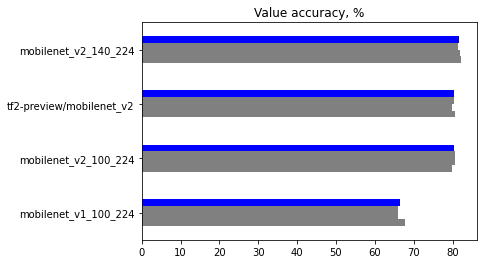

In [27]:
value_accuracy_groups = [
    [67.88, 65.93, 65.90, 66.57], 
    [79.98, 80.53, 80.53, 80.35], 
    [80.73, 79.98, 80.34, 80.35],
    [82.07, 81.81, 81.32, 81.73]
]
accuracy_group_labels = ['mobilenet_v1_100_224', 'mobilenet_v2_100_224', 
                         'tf2-preview/mobilenet_v2', 'mobilenet_v2_140_224']

df = pd.DataFrame(value_accuracy_groups, index=accuracy_group_labels)

ax = df.plot.barh(title="Value accuracy, %", color=['grey', 'grey', 'grey', 'blue'], legend=False)

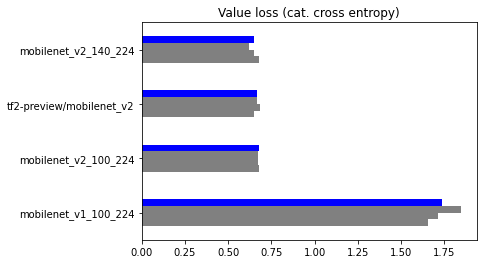

In [28]:
value_loss_groups = [
    [1.656, 1.716, 1.844, 1.739], 
    [0.681, 0.674, 0.673, 0.676], 
    [0.651, 0.687, 0.664, 0.667],
    [0.678, 0.647, 0.621, 0.649]
]
loss_group_labels = ['mobilenet_v1_100_224', 'mobilenet_v2_100_224', 
                         'tf2-preview/mobilenet_v2', 'mobilenet_v2_140_224']

df = pd.DataFrame(value_loss_groups, index=loss_group_labels)

ax = df.plot.barh(title="Value loss (cat. cross entropy)", color=['grey', 'grey', 'grey', 'blue'], legend=False)

Finally, we summarize the results in a table.


| Model no | Name |  Mean value accuracy, % | Mean value loss (cat. cross entropy) |
| --- | --- | --- | -- |
| 1 | imagenet/mobilenet_v1_100_224/classification  | 66.57 | 1.739 |
| 2 | imagenet/mobilenet_v2_100_224/classification  | 80.35 | 0.676 |
| 3 | tf2-preview/mobilenet_v2/classification | 80.35 | 0.667 |
| 4 | imagenet/mobilenet_v2_140_224/classification  | 81.73 | 0.649 |

From the table it can be concluded that the best model based on defined criterias are number 4, `imagenet/mobilenet_v2_140_224/classification`. It has the highest accuracy and lowest loss, although model 2-4 has very similar performance.